In [102]:
from skimage import io
from skimage import transform
import numpy as np
import random
import math

# Funcion which creates array of puzzle pieces
# From a given picture

def from_image_to_pieces(image_path, n_rows, n_cols):
  
  image = io.imread(image_path)

  size = image.shape
  size = min(size[0], size[1])
  
  image = image[0:size, 0:size]

  step = math.floor(size / n_rows)
  
  pieces = []

  for i in range(n_rows):
    for j in range(n_cols):
      pieces.append(np.array(image[i*step: (i+1)*step, j*step : (j+1)*step]))

  return pieces

pieces = make_puzzle("lion.jpg", 5, 5)

In [103]:
def shuffle(pieces):
  random.shuffle(pieces)

  result = []

  for x in pieces:
    i = random.randint(0, 4)
    x = transform.rotate(x, i*90)
    result.append(x)

  return result

pieces = shuffle(pieces)


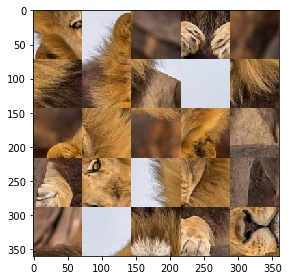

In [104]:
def make_image(pieces, step, n_rows, n_cols):

  image = np.array([])
  image = np.resize(image, (n_rows*step, n_cols*step, 3))

  for i in range(n_rows):
    for j in range(n_cols):
      image[i*step : (i+1)*step, j*step : (j+1)*step] = pieces[i*n_cols + j]
    
  io.imshow(image)
  io.imsave("slika.jpg", image)

make_image(pieces, 72, 5, 5)